# Combining climate projections and observations to reduce climate uncertainty: a case study with the KCC R package

This notebook is a companion to the paper 'Reducing climate uncertainty in local temperature projections' by Qasmi and Ribes (2022): https://doi.org/10.21203/rs.3.rs-364943/v3. The Kriging for Climate Change (KCC) package (available at: https://gitlab.com/saidqasmi/KCC) is here used to constrain climate projections from CMIP6 models for the following variables:
- global mean surface temperature (GMST), as done in Ribes et al 2021: https://doi.org/10.1126/sciadv.abc0671
- temperature on a grid point of 2.5 x 2.5 degree centered over Dallas in North America [33.75°N ; 98.75° W].

In [1]:
# Loading KCC package
library(KCC)
# and other useful package(s)
library(abind)

Warning message:
“package ‘abind’ was built under R version 4.3.3”


In [2]:
# Set random number generator to ensure reproducibility
set.seed(1)

# Sample size to derive normal distributions
Nres = 1000
sample_str = c("be", paste0("nres",1:Nres))

Some useful plotting functions:

In [3]:
plot_cons = function(X_krig, Xo, ref_plot=NULL, ny=ny, ylim=NULL, color="red") {
    par(font.lab=2,font.axis=2,cex.lab=1.2,mar=c(4,4,1,1),mgp=c(2.5,.7,0))
    x = X_krig[1:ny,,"all","uncons"]
    x_cons = X_krig[1:ny,,"all","cons"]
    obs_x = apply(Xo,1,median)

    # set the ref at the preindustrial level
    ref_plot = 1850:1900
    x = x - ones(x[,1]) %o% apply(x[year %in% ref_plot,], 2, mean)
    x_cons = x_cons - ones(x_cons[,1]) %o% apply(x_cons[year %in% ref_plot,], 2, mean)
    obs_x = obs_x - mean(obs_x[year_obsN %in% ref_plot])

    # compute spread
    x_q95 = apply(x[,-1],1,quantile,.95)
    x_q05 = apply(x[,-1],1,quantile,.05)
    xc_q95 = apply(x_cons[,-1],1,quantile,.95)
    xc_q05 = apply(x_cons[,-1],1,quantile,.05)

    plot(year_obsN, obs_x, xlim=range(year), ylim=ylim, type="p", pch=16, cex=.8, xlab="Year", ylab="Temperature (K)", panel.first=abline(v=NA,col="gray"))
    yaxp = par("yaxp")
    yticks = seq( yaxp[1], yaxp[2], (yaxp[2]-yaxp[1])/yaxp[3] )
    abline(h=yticks,lty=3)
    
    if (color == "red") {
        polygon(c(year,rev(year)), c(x_q95,rev(x_q05)),border=NA,col=rgb(1,0,0,alpha=.2))
        polygon(c(year,rev(year)), c(xc_q95,rev(xc_q05)),border=NA,col=rgb(1,0,0,alpha=.5))
        colb = col2rgb("brown")/255
    } else if (color == "blue") {
        polygon(c(year,rev(year)), c(x_q95,rev(x_q05)),border=NA,col=rgb(0,0,1,alpha=.2))
        polygon(c(year,rev(year)), c(xc_q95,rev(xc_q05)),border=NA,col=rgb(0,0,1,alpha=.5))
        colb = col2rgb("blue")/255
    }
    
    lines(year,x[,1],lwd=1.5,col=rgb(colb[1],colb[2],colb[3],alpha=.5))
    lines(year,x_cons[,1],lwd=2,col=rgb(colb[1],colb[2],colb[3],alpha=1))
}


## Estimation of the temperature response to the natural forcings

### Reponse to natural forcings

First, we estimate the response to natural forcings in each CMIP6 model. The response `e` (a gaussian distribution of `Nres` realisations) is then derived. We will use this distribution for both local and global temperature projections.

,models_name,F,lamb,gamm,c,c0
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BCC,6.700000,1.21,0.7100000,7.800000,52.0000
2,CCCMA,7.600000,1.03,0.6900000,7.300000,64.0000
3,CNRM,7.100000,1.08,0.4700000,10.000000,130.0000
4,CSIRO,5.100000,0.61,0.9200000,6.200000,68.0000
5,GFDL,6.600000,1.34,0.8700000,8.100000,110.0000
6,INM,6.200000,1.51,0.6600000,8.900000,314.0000
7,IPSL,6.400000,0.78,0.6000000,9.900000,98.0000
8,MIROC,8.500000,1.58,0.6400000,8.200000,134.0000
9,MPIM,8.200000,1.14,0.7600000,7.300000,70.0000


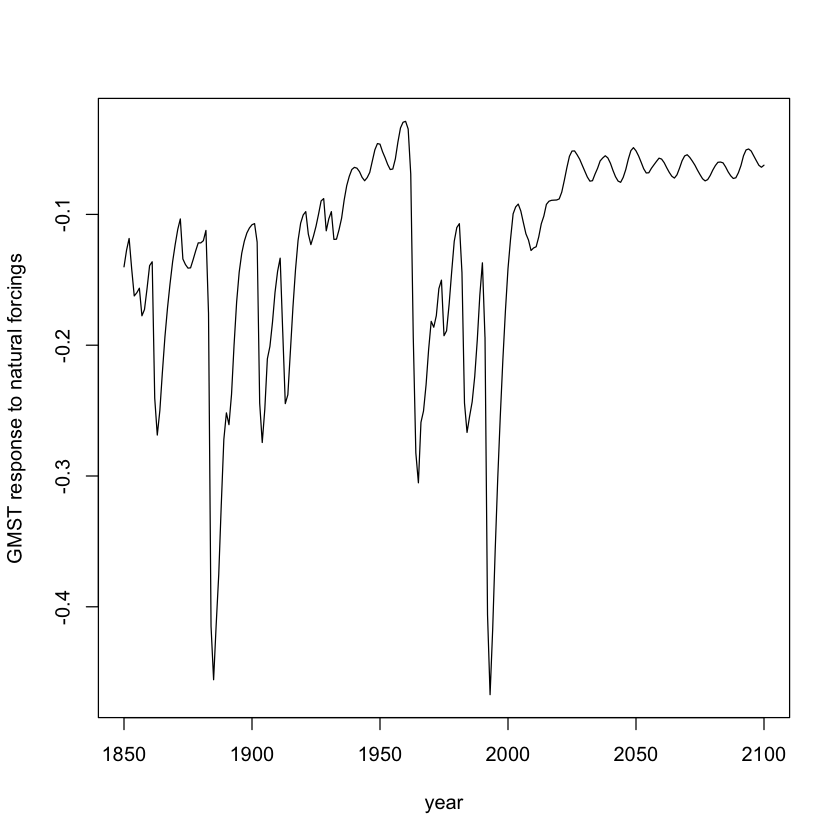

In [4]:
year = 1850:2100
ny = length(year)

# Load forcings from the Priestley Center
load("FF_CMIP6.rda")
# Plot if needed
#plot(year,FF$FF$nat[FF$FF$year %in% year],type="l")

# Load EBM parameters fitted on available CMIP6 models
load("ebm_params.rda")

ebm_params

# Compute the EBM response e, to be used in equation 7 in Qasmi and Ribes (2021)
e = ebm_response(FF,ebm_params,year,Nres)

# Plot the best-estimate of e
plot(year,e[,"be"],type="l", ylab="GMST response to natural forcings")

### Reponse to the anthropogenic and all external forcings for GMST

We estimate the response to anthropogenic and all forcings by fitting a Generalized Additive Model (GAM) on each ensemble mean from the CMIP6 models. An uncertainty on each forced response is considered by using the pre-industrial control (piControl) simulations.

First, we pre-process the input variables:

In [5]:
# Load historical+ssp585 GMST ensemble means from CMIP6 models
X_glo_scen_tmp = loadRData("GMST_CMIP6_histssp585_ann_idx.Rdata")

# Extract the scenario and the chosen simulated years
X_glo_scen_full = X_glo_scen_tmp[as.character(year),"histssp585",,]

# Consider the same models in historical+ssp585 and piControl simulations
models_scen_full = dimnames(X_glo_scen_full)$model
# Check if any NA in times series
models = models_scen_full[apply(is.na(X_glo_scen_full[,,"value"]), 2, sum) == 0] 
# The following CMIP6 models will be used to derive the prior
models

Nmod = length(models)
X_glo_scen = X_glo_scen_full[,models,]

[1] "ACCESS-CM2"      "ACCESS-ESM1-5"   "BCC-CSM2-MR"     "CanESM5-CanOE"  
 [5] "CanESM5"         "CESM2"           "CESM2-WACCM"     "CNRM-CM6-1"     
 [9] "CNRM-CM6-1-HR"   "CNRM-ESM2-1"     "EC-Earth3"       "EC-Earth3-Veg"  
[13] "FGOALS-f3-L"     "FGOALS-g3"       "FIO-ESM-2-0"     "GFDL-ESM4"      
[17] "HadGEM3-GC31-LL" "INM-CM4-8"       "INM-CM5-0"       "IPSL-CM6A-LR"   
[21] "MIROC6"          "MIROC-ES2L"      "MPI-ESM1-2-HR"   "MPI-ESM1-2-LR"  
[25] "MRI-ESM2-0"      "NESM3"           "NorESM2-MM"      "UKESM1-0-LL"

Now, we can fit the GAM on each CMIP6 ensemble mean given the response to natural forcings `e`, and the degrees of freedom `df` for the spline function.

In [6]:
dec_glo = T #

if (dec_glo == T) {
    # Extract the forced response to ALL and NAT forcings and fit to a Gaussian distribution
    X_fit_glo = array(NA, dim = c(ny, 2, Nmod),
                  dimnames = list(year = as.character(year),
                                forcing = c("all","nat"),
                                model = models))
    # degrees of freedom for the spline function
    df = 6                            
    message("Decomposition for each model (take some time!)...")
    X_fit_glo[,c("all","nat"),] = x_fit(X_glo_scen[,,"value"], e, df, ant=F)
} else {
    X_fit_glo = loadRData("X_fit_GMST_CMIP6_histssp585_ann.Rdata")
}

Decomposition for each model (take some time!)...

		ACCESS-CM2

		ACCESS-ESM1-5

		BCC-CSM2-MR

		CanESM5-CanOE

		CanESM5

		CESM2

		CESM2-WACCM

		CNRM-CM6-1

		CNRM-CM6-1-HR

		CNRM-ESM2-1

		EC-Earth3

		EC-Earth3-Veg

		FGOALS-f3-L

		FGOALS-g3

		FIO-ESM-2-0

		GFDL-ESM4

		HadGEM3-GC31-LL

		INM-CM4-8

		INM-CM5-0

		IPSL-CM6A-LR

		MIROC6

		MIROC-ES2L

		MPI-ESM1-2-HR

		MPI-ESM1-2-LR

		MRI-ESM2-0

		NESM3

		NorESM2-MM

		UKESM1-0-LL



Plot the decomposition for the ACCESS-CM2 model (change the loop in the third cell to test other models if necessary), and check that the decomposition of GMST is correct.

### Modeling observed internal variability within GMST with a Mixture of two Autoregressive (MAR) processes of order 1

We use observations from the Cowtan and Way dataset: https://www-users.york.ac.uk/~kdc3/papers/coverage2013/series.html to compute $\Sigma_\mathrm{obs} = \Sigma_\mathrm{meas.} + \Sigma_\mathrm{iv}$, the observation error covariance matrix. 

In [8]:
# Load observed GMST from Cowtan & Way over 1850-2019
#library(data.table) 
year_obsN = 1850:2024
year_obsO = 1850:2019
ref_obs = 1961:1990
ny_obs = length(year_obsN)
Xo_glo_fullCW = loadRData("GMST_CW_ann.Rdata")

Xo_glo_full = read.csv("HadCRUT.5.0.2.0.analysis.ensemble_series.global.annual.csv",row.names = 1,)
Xo_gloNew = Xo_glo_full[-c(1,2)]
colnames(Xo_gloNew)=1:200
Xo_glo <- data.matrix(Xo_gloNew, rownames.force = NA)

#RETAIN OLD DATASET TO COMPARE
Xo_glo_CW = Xo_glo_fullCW[as.character(year_obsO),]

# Check the ensemble size: 170 years, 100 members
#dim(Xo_glo)
dim(Xo_glo)


[1] 175 200

We first build the covariance matrix for internal variability $\Sigma_\mathrm{iv,glo}$, by fitting the MAR parameters to an estimate of observed internal variability.

In [9]:
# Estimate the response to all external forcings by the multimodel ensemble mean
raw_mmm = apply(X_fit_glo[,"all",], 1, mean, na.rm=T)
# Calculate obs residuals, our estimate of internal variability
raw_mmm_c = raw_mmm - mean(raw_mmm[year %in% ref_obs]) # raw_mmm_c must be anomalies wrt 1961-1990
Xo_glo_med = apply(Xo_glo, 1, median)
Xo_glo_c = Xo_glo_med - mean(Xo_glo_med[year_obsN %in% ref_obs])
res_glo = Xo_glo_c - raw_mmm_c[as.character(year_obsN)]
# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta_obs_glo = estim_mar2_link(res_glo)
# Compute the associated covariance matrix
Sigma2_obs_iv_glo = Sigma_mar2(theta_obs_glo,res_glo)


Fitting MAR parameters (may take some time!)...



initial  value -632.213287 
iter   2 value -633.073669
iter   3 value -633.957872
iter   4 value -635.059149
iter   5 value -635.452069
iter   6 value -636.783110
iter   7 value -637.192094
iter   8 value -637.420335
iter   9 value -637.556642
iter  10 value -637.635542
iter  11 value -637.636623
iter  12 value -637.639424
iter  13 value -637.641042
iter  14 value -637.642529
iter  15 value -637.650457
iter  16 value -637.651729
iter  17 value -637.651895
iter  17 value -637.651897
iter  17 value -637.651897
final  value -637.651897 
converged


[1] 251

[1] 175

[1] 251   2  28

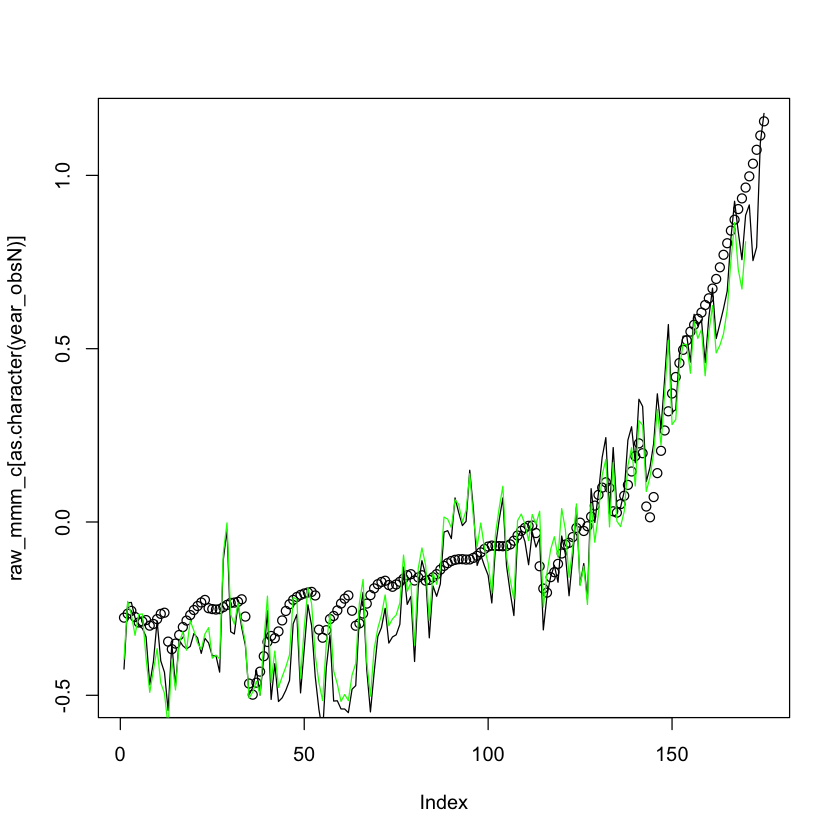

In [10]:

Xo_glo_medCW = apply(Xo_glo_CW, 1, median)
Xo_glo_cCW = Xo_glo_medCW - mean(Xo_glo_medCW[year_obsO %in% ref_obs])

res_gloCW = Xo_glo_cCW - raw_mmm_c[as.character(year_obsO)]

plot(raw_mmm_c[as.character(year_obsN)])
lines(Xo_glo_c)
lines(Xo_glo_cCW,col='green')
length(raw_mmm_c)
length(Xo_glo_c)
dim(X_fit_glo)

[1] 175 175


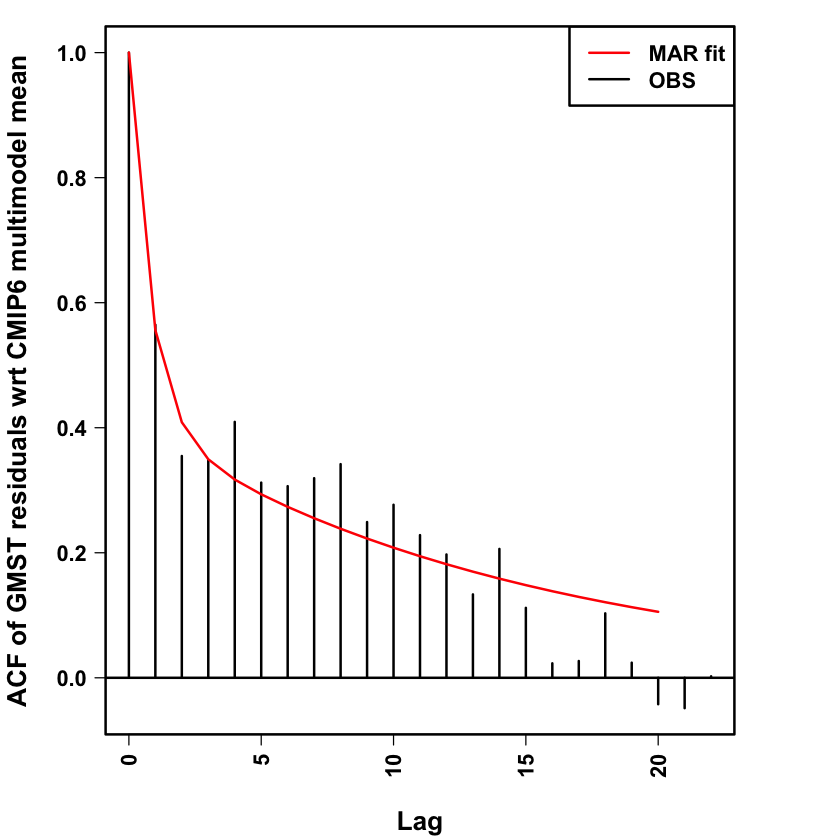

In [11]:
# Check that MAR modelling is ok
print(dim(Sigma2_obs_iv_glo))
acf_res = acf(res_glo, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of GMST residuals wrt CMIP6 multimodel mean",ci=0,lwd=2)
colors_acf = c("red", "black")
lines(0:20, Sigma2_obs_iv_glo[1,1:21]/Sigma2_obs_iv_glo[1,1], col=colors_acf[1], lwd=2)
legend("topright", legend = c("MAR fit", "OBS"), col = colors_acf, lwd=2, lty=1)

The covariance matrix for measurement errors is computed over the 100 members.

In [12]:
# Add the covariance matrix for measurement errors
Sigma2_obs_glo = Sigma2_obs_iv_glo + var(t(Xo_glo))

### Constraint of the GMST projections

All the ingredients are now gathered to apply the constraint using the gaussian conditioning theorem.

In [13]:
dim(X_fit_glo)
dim(Xo_glo)
dim(Sigma2_obs_glo)


[1] 251   2  28

[1] 175 200

[1] 175 175

In [14]:
#rownames(X_fit_glo) 
#rownames(Xo_glo)
year = as.integer(dimnames(X_fit_glo)$year)

#print(year_S_str)
names(dimnames(Xo_glo))<-names(dimnames(Xo_glo_CW))
print(names(dimnames(Xo_glo)))

[1] "year"   "member"


In [15]:
# Constrain of GMST
message("Retrieve the results from Ribes et al. 2020 by constraining simulated GMST by observations")
X_krig_glo_list = prior2posterior(X_fit_glo, Xo_glo, Sigma2_obs_glo, Nres, centering_CX=T, ref_CX=1850:1900)

# Convert output lists to arrays
# X_unconstrained
X_uncons_glo = mvgauss_to_Xarray(X_krig_glo_list$uncons$mean,X_krig_glo_list$uncons$var,Nres)
# X_constrained
X_cons_glo = mvgauss_to_Xarray(X_krig_glo_list$cons$mean,X_krig_glo_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
library(abind)
l_tmp = c(dimnames(X_uncons_glo)[1:3], list(constrain=c("uncons","cons")))
X_krig_glo = abind(X_uncons_glo, X_cons_glo, along=4)
dimnames(X_krig_glo) = l_tmp

Retrieve the results from Ribes et al. 2020 by constraining simulated GMST by observations



Check the kriging performance by plotting prior and posterior distributions (see Figure 2c in Ribes et al 2021):

[1] 1850 2100

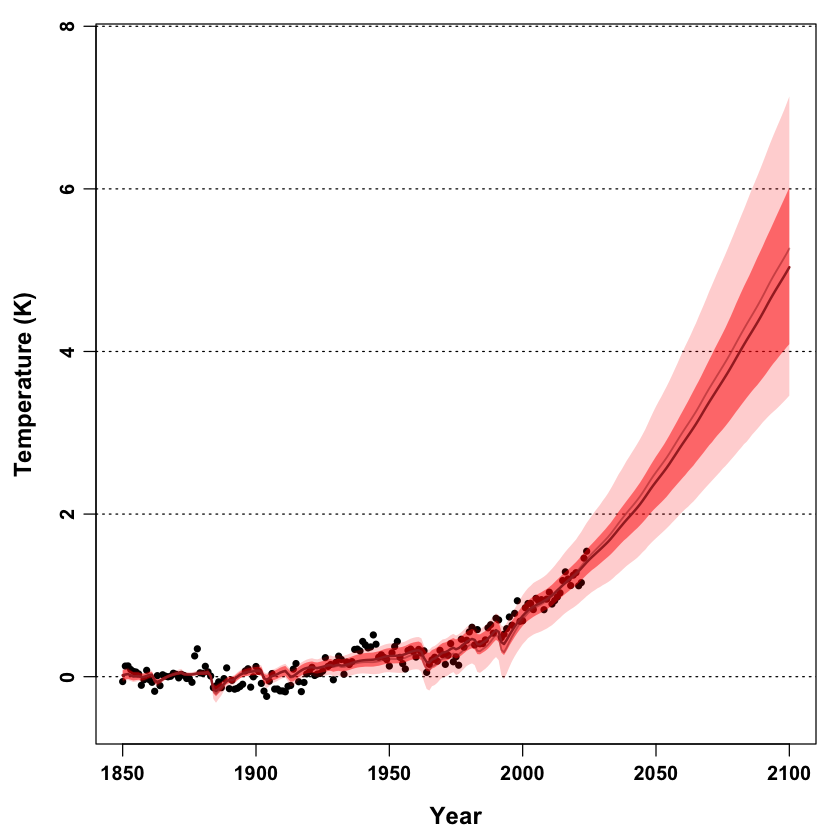

In [16]:
ylim = c(-.5,7.7)
ref_plot = 1850:1900
range(as.integer(year))
plot_cons(X_krig_glo, Xo_glo, ref_plot=ref_plot, ny=ny, ylim=ylim)

In [20]:
dim(X_cons_glo)
dimnames(X_cons_glo)

[1]  251 1001    2

$year
  [1] "1850" "1851" "1852" "1853" "1854" "1855" "1856" "1857" "1858" "1859"
 [11] "1860" "1861" "1862" "1863" "1864" "1865" "1866" "1867" "1868" "1869"
 [21] "1870" "1871" "1872" "1873" "1874" "1875" "1876" "1877" "1878" "1879"
 [31] "1880" "1881" "1882" "1883" "1884" "1885" "1886" "1887" "1888" "1889"
 [41] "1890" "1891" "1892" "1893" "1894" "1895" "1896" "1897" "1898" "1899"
 [51] "1900" "1901" "1902" "1903" "1904" "1905" "1906" "1907" "1908" "1909"
 [61] "1910" "1911" "1912" "1913" "1914" "1915" "1916" "1917" "1918" "1919"
 [71] "1920" "1921" "1922" "1923" "1924" "1925" "1926" "1927" "1928" "1929"
 [81] "1930" "1931" "1932" "1933" "1934" "1935" "1936" "1937" "1938" "1939"
 [91] "1940" "1941" "1942" "1943" "1944" "1945" "1946" "1947" "1948" "1949"
[101] "1950" "1951" "1952" "1953" "1954" "1955" "1956" "1957" "1958" "1959"
[111] "1960" "1961" "1962" "1963" "1964" "1965" "1966" "1967" "1968" "1969"
[121] "1970" "1971" "1972" "1973" "1974" "1975" "1976" "1977" "1978" "1979"
[131] "1980" "1981" "1982" "1983" "1984" "1985" "1986" "1987" "1988" "1989"
[141] "1990" "1991" "1992" "1993" "1994" "1995" "1996" "1997" "1998" "1999"
[151] "2000" "2001" "2002" "2003" "2004" "2005" "2006" "2007" "2008" "2009"
[161] "2010" "2011" "2012" "2013" "2014" "2015" "2016" "2017" "2018" "2019"
[171] "2020" "2021" "2022" "2023" "2024" "2025" "2026" "2027" "2028" "2029"
[181] "2030" "2031" "2032" "2033" "2034" "2035" "2036" "2037" "2038" "2039"
[191] "2040" "2041" "2042" "2043" "2044" "2045" "2046" "2047" "2048" "2049"
[201] "2050" "2051" "2052" "2053" "2054" "2055" "2056" "2057" "2058" "2059"
[211] "2060" "2061" "2062" "2063" "2064" "2065" "2066" "2067" "2068" "2069"
[221] "2070" "2071" "2072" "2073" "2074" "2075" "2076" "2077" "2078" "2079"
[231] "2080" "2081" "2082" "2083" "2084" "2085" "2086" "2087" "2088" "2089"
[241] "2090" "2091" "2092" "2093" "2094" "2095" "2096" "2097" "2098" "2099"
[251] "2100"

$sample
   [1] "be"       "nres1"    "nres2"    "nres3"    "nres4"    "nres5"   
   [7] "nres6"    "nres7"    "nres8"    "nres9"    "nres10"   "nres11"  
  [13] "nres12"   "nres13"   "nres14"   "nres15"   "nres16"   "nres17"  
  [19] "nres18"   "nres19"   "nres20"   "nres21"   "nres22"   "nres23"  
  [25] "nres24"   "nres25"   "nres26"   "nres27"   "nres28"   "nres29"  
  [31] "nres30"   "nres31"   "nres32"   "nres33"   "nres34"   "nres35"  
  [37] "nres36"   "nres37"   "nres38"   "nres39"   "nres40"   "nres41"  
  [43] "nres42"   "nres43"   "nres44"   "nres45"   "nres46"   "nres47"  
  [49] "nres48"   "nres49"   "nres50"   "nres51"   "nres52"   "nres53"  
  [55] "nres54"   "nres55"   "nres56"   "nres57"   "nres58"   "nres59"  
  [61] "nres60"   "nres61"   "nres62"   "nres63"   "nres64"   "nres65"  
  [67] "nres66"   "nres67"   "nres68"   "nres69"   "nres70"   "nres71"  
  [73] "nres72"   "nres73"   "nres74"   "nres75"   "nres76"   "nres77"  
  [79] "nres78"   "nres79"   "nres80"   "nres81"   "nres82"   "nres83"  
  [85] "nres84"   "nres85"   "nres86"   "nres87"   "nres88"   "nres89"  
  [91] "nres90"   "nres91"   "nres92"   "nres93"   "nres94"   "nres95"  
  [97] "nres96"   "nres97"   "nres98"   "nres99"   "nres100"  "nres101" 
 [103] "nres102"  "nres103"  "nres104"  "nres105"  "nres106"  "nres107" 
 [109] "nres108"  "nres109"  "nres110"  "nres111"  "nres112"  "nres113" 
 [115] "nres114"  "nres115"  "nres116"  "nres117"  "nres118"  "nres119" 
 [121] "nres120"  "nres121"  "nres122"  "nres123"  "nres124"  "nres125" 
 [127] "nres126"  "nres127"  "nres128"  "nres129"  "nres130"  "nres131" 
 [133] "nres132"  "nres133"  "nres134"  "nres135"  "nres136"  "nres137" 
 [139] "nres138"  "nres139"  "nres140"  "nres141"  "nres142"  "nres143" 
 [145] "nres144"  "nres145"  "nres146"  "nres147"  "nres148"  "nres149" 
 [151] "nres150"  "nres151"  "nres152"  "nres153"  "nres154"  "nres155" 
 [157] "nres156"  "nres157"  "nres158"  "nres159"  "nres160"  "nres161" 
 [163] "nres162"  "nres163"  "nres164"  "nres165"  "nres166"  "nres167" 
 [169] "nres168"  "nres169" 

### Reponse to the anthropogenic and all external forcings of the local temperature over 

As done for the GMST, we fit a GAM on each CMIP6 model ensemble mean and consider local time series over Dallas, by applying the same above procedure. For the sake of simplicity, here we load directly the local response returned by `x_fit`.

In [ ]:
message("Load simulated local temperature responses to external forcings")
X_fit_loc = loadRData("X_fit_tblend_CMIP6_histssp585_ann_Dallas.Rdata")

### Modeling observed local internal variability with the MAR statistical representation

Similarly to the GMST case, we estimate local internal variability using observed temperatures in Dallas:

In [ ]:
message("Load observed local temperatures from Cowtan & Way over 1850-2019")
Xo_loc_full = loadRData("tblend_CW_ann_Dallas.Rdata")
Xo_loc = Xo_loc_full[as.character(year_obs),]

Computation of $\Sigma_\mathrm{iv,loc}$:

In [ ]:
# Estimate the response to all external forcings by the multimodel ensemble mean
raw_mmm = apply(X_fit_loc[,"be","all",], 1, mean, na.rm=T)
# Calculate obs residuals, our estimate of internal variability 
raw_mmm_c = raw_mmm - mean(raw_mmm[year %in% ref_obs]) # raw_mmm_c must be anomalies wrt 1961-1990
Xo_loc_med = apply(Xo_loc, 1, median)
Xo_loc_c = Xo_loc_med - mean(Xo_loc_med[year_obs %in% ref_obs])
res_loc = Xo_loc_c - raw_mmm_c[as.character(year_obs)]
# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta_obs_loc = estim_mar2_link(res_loc)
# Compute the associated covariance matrix
Sigma2_obs_iv_loc = Sigma_mar2(theta_obs_loc,res_loc)


In [ ]:
# Check that MAR modelling is ok
acf_res = acf(res_loc, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of residuals wrt CMIP6 multimodel mean",ci=0,lwd=2)
colors_acf = c("blue", "black")
lines(0:20, Sigma2_obs_iv_loc[1,1:21]/Sigma2_obs_iv_loc[1,1], col=colors_acf[1], lwd=2)
legend("topright", legend = c("MAR fit", "Local OBS"), col = colors_acf, lwd=2, lty=1)


In [ ]:
# Add the covariance matrix for measurement errors
Sigma2_obs_loc = Sigma2_obs_iv_loc + var(t(Xo_loc))

### Constraint of the local temperature projections over Dallas

Once again, we constrain temperature projections, but for Dallas. The two options mentionned in Qasmi and Ribes (2021) are tested.

#### Constraint by local+global observations

First option: using both GMST observations and local observations.

In [ ]:
models = intersect(dimnames(X_fit_loc)$model,dimnames(X_fit_glo)$model)

# Bind arrays containing the local and global responses returned by x_fit
X_fit = abind(X_fit_loc[,"be",,models], X_fit_glo[,,models], along=1, use.dnns=T)
# Rearrange dimensions along year dimension
year_loc = paste0(as.character(year),"loc")
year_glo = paste0(as.character(year),"glo")
dimnames(X_fit)$year = c(year_loc, year_glo)

# Bind arrays containing the local and global observations
Xo = abind(Xo_loc, Xo_glo, along=1, use.dnns=T)
year_obs_loc = paste0(as.character(year_obs),"loc")
year_obs_glo = paste0(as.character(year_obs),"glo")
dimnames(Xo)$year = c(year_obs_loc, year_obs_glo)

Since we are dealing with both local and global observations, we need to account for the dependance between local and global residuals, and compute $\Sigma_\mathrm{iv,dep}$, the anti-diagonal block in $\Sigma_\mathrm{iv}$ see equation 10 in Supplementary Material of Qasmi and Ribes (2021).

In [ ]:
message("Accounting for dependence parameters in the covariance matrix")
res_loc_glo = list(res_loc, res_glo)
theta_obs_loc_glo = estim_mar_dep(theta_obs_loc,theta_obs_glo,res_loc_glo) # by the method of moments
#theta_obs_loc_glo = estim_mar_dep_full(res_loc_glo) # by maximum likelihood (takes some time)

# Compute the associated covariance matrix
Sigma2_obs_iv_loc_glo = Sigma_mar_dep(theta_obs_loc_glo,res_loc_glo)

# Check that the dimensions are correct
dim(Sigma2_obs_iv_loc_glo)

In [ ]:
# Add the covariance matrix for measurement errors
Sigma2_obs_loc_glo = Sigma2_obs_iv_loc_glo + var(t(Xo))

In [ ]:
# Constrain by local+global observations
X_krig_loc_glo_list = prior2posterior(X_fit, Xo, Sigma2_obs_loc_glo, Nres, centering_CX=T, ref_CX=c(paste0(1850:1900,"loc"),paste0(1850:1900,"glo")))

# Convert output lists to arrays
# X_unconstrained
X_uncons_loc_glo = mvgauss_to_Xarray(X_krig_loc_glo_list$uncons$mean,X_krig_loc_glo_list$uncons$var,Nres)
# X_constrained
X_cons_loc_glo = mvgauss_to_Xarray(X_krig_loc_glo_list$cons$mean,X_krig_loc_glo_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
l_tmp = c(dimnames(X_uncons_loc_glo)[1:3], list(constrain=c("uncons","cons")))
X_krig_loc_glo = abind(X_uncons_loc_glo, X_cons_loc_glo, along=4)
dimnames(X_krig_loc_glo) = l_tmp

Check the kriging performance by plotting prior and posterior distributions (see Figure 2b in Qasmi and Ribes 2021):

In [ ]:
ylim = c(-1.,9.)
ref_plot = 1850:1900

dimnames(X_krig_loc_glo)$year = c(year,year_glo)
plot_cons(X_krig_loc_glo, Xo_loc, ref_plot=ref_plot, ny=ny, ylim=ylim,color="blue")

#### Constraint by GMST observations only

Second option: using GMST observations only. We keep the structure of the binded array of the local and global temperature responses, and only use GMST observations as input in the `prior2posterior` function.

In [ ]:
# Rename year dimension of GMST
dimnames(Xo_glo)$year = year_obs_glo

# Constraint by GMST observations only
X_krig_glo_only_list = prior2posterior(X_fit, Xo_glo, Sigma2_obs_glo, Nres, centering_CX=T, ref_CX=paste0(1850:1900,"glo"))

# Convert output lists to arrays
# X_unconstrained
X_uncons_glo_only = mvgauss_to_Xarray(X_krig_glo_only_list$uncons$mean,X_krig_glo_only_list$uncons$var,Nres)
# X_constrained
X_cons_glo_only = mvgauss_to_Xarray(X_krig_glo_only_list$cons$mean,X_krig_glo_only_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
l_tmp = c(dimnames(X_uncons_glo_only)[1:3], list(constrain=c("uncons","cons")))
X_krig_glo_only = abind(X_uncons_glo_only, X_cons_glo_only, along=4)
dimnames(X_krig_glo_only) = l_tmp

Check the kriging performance by plotting prior and posterior distributions (see Figure 2a in Qasmi and Ribes 2021):

In [ ]:
# Rename year dimension
dimnames(Xo_glo)$year = year_obs
dimnames(X_krig_glo_only)$year = c(year,year_glo)

# Plot
ylim = c(-1.,9.)
ref_plot = 1850:1900
Xo_loc_plot = Xo_loc+NA # we do not want local observations on the plot since they are not used in the constraint
plot_cons(X_krig_glo_only, Xo_loc, ref_plot=ref_plot, ny=ny, ylim=ylim)

We can verify that model uncertainty is larger than in the Local+GMST case of about 0.5 degrees in 2100:

In [ ]:
write_ci = function(v) {
    message("   ",round(v["be"],2),", [",round(quantile(v[-1],.05),2),", ",round(quantile(v[-1],.95),2),"]")
}

delta_2100_loc_glo = X_krig_loc_glo["2100",,"all","cons"] - apply(X_krig_loc_glo[year %in% 1850:1900,,"all","cons"],2,mean)
delta_2100_glo_only = X_krig_glo_only["2100",,"all","cons"] - apply(X_krig_glo_only[year %in% 1850:1900,,"all","cons"],2,mean)

message("Best-estimate and confidence interval in the Local+GMST case")
write_ci(delta_2100_loc_glo)
message("Best-estimate and confidence interval in the GMST-only case")
write_ci(delta_2100_glo_only)


#### Additional option: constraint by local observations only

A third and last option mentionned in the Supplementary Information of Qasmi and Ribes (2021) is to use local observations only to perform the kriging interpolation.

In [ ]:
dimnames(Xo_loc)$year = year_obs_loc


In [ ]:
# Constrain by local observations only
X_krig_loc_list = prior2posterior(X_fit, Xo_loc, Sigma2_obs_loc_glo[year_obs_loc,year_obs_loc], Nres, centering_CX=T, ref_CX=paste0(1850:1900,"loc"))

# Convert output lists to arrays
# X_unconstrained
X_uncons_loc = mvgauss_to_Xarray(X_krig_loc_list$uncons$mean,X_krig_loc_list$uncons$var,Nres)
# X_constrained
X_cons_loc = mvgauss_to_Xarray(X_krig_loc_list$cons$mean,X_krig_loc_list$cons$var,Nres)

# Bind X_uncons and X_cons together using the abind library
l_tmp = c(dimnames(X_uncons_loc)[1:3], list(constrain=c("uncons","cons")))
X_krig_loc = abind(X_uncons_loc, X_cons_loc, along=4)
dimnames(X_krig_loc) = l_tmp

Check the kriging performance by plotting prior and posterior distributions:

In [ ]:
ylim = c(-1.,9.)
ref_plot = 1850:1900
plot_cons(X_krig_loc, Xo_loc, ref_plot=ref_plot, ny=ny, ylim=ylim, color="blue")